In [2]:
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms_wrapper
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
%matplotlib inline

In [4]:
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16',
                  'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF',
                  'ZF_faster_rcnn_final.caffemodel')}

In [5]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    print "before im detect"
    scores, boxes = im_detect(net, im)
    print "after im detect"
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Faster R-CNN demo')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU device id to use [0]',
                        default=0, type=int)
    parser.add_argument('--cpu', dest='cpu_mode',
                        help='Use CPU mode (overrides --gpu)',
                        action='store_true')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16]',
                        choices=NETS.keys(), default='vgg16')

    #args = parser.parse_args()
    return parser
    #return args

In [6]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals
demo_net = 'vgg16'

#cfg.RPN_BATCHSIZE = 16
#cfg.BATCH_SIZE = 16
#cfg

In [7]:
prototxt = os.path.join(cfg.MODELS_DIR, NETS[demo_net][0],
                        'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS[demo_net][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))


caffe.set_mode_gpu()
caffe.set_device(0)
cfg.GPU_ID = 0
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)



Loaded network /data/workspace/jg_pfr/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/0000873-000002922482.jpg
before im detect
after im detect
Detection took 0.156s for 300 object proposals


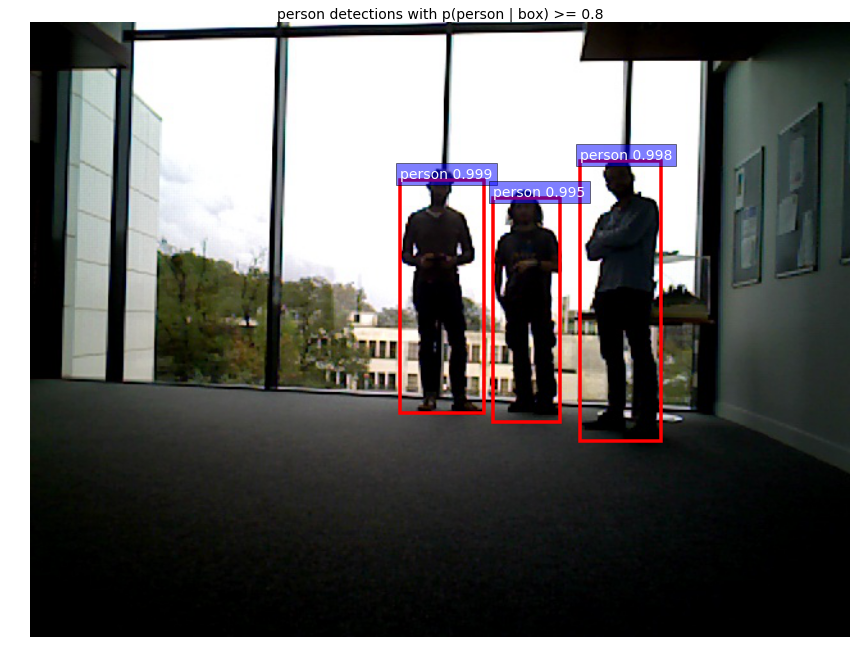

In [9]:
# Warmup on a dummy image
#im = 128 * np.ones((300, 500, 3), dtype=np.uint8)
#for i in xrange(2):
#    _, _= im_detect(net, im)

#im_names = ['000456.jpg', '000542.jpg', '001150.jpg',
#            '001763.jpg', '004545.jpg']

im_names = ['0000873-000002922482.jpg']


for im_name in im_names:
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/{}'.format(im_name)
    demo(net, im_name)

plt.show()

In [ ]:
str(round(0.133/300*1000*1000)/1000)+" ms per bounding box proposal"